In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import LabelEncoder

# Download required nltk resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samithlakka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samithlakka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True


## Data Exploration

To understand the dataset, we first explore the feature distributions and check for missing values. 
This helps us identify potential issues before applying machine learning models.


In [4]:
# Load dataset
df = pd.read_csv('/Users/samithlakka/Desktop/Capstone 3/WELFake_Dataset.csv')  # Change this to actual dataset path

# Display basic dataset info
print(df.info())
print(df.head())

# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Check for class distribution (real vs fake)
print("Class Distribution:\n", df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB
None
   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2 


## Text Preprocessing

The text data needs to be cleaned and preprocessed before modeling. The following steps are applied:
1. Convert text to lowercase.
2. Remove punctuation and special characters.
3. Remove stopwords.
4. Apply lemmatization to normalize words.

In [5]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Drop rows with missing values in key columns
df.dropna(subset=['title', 'text'], inplace=True)

# Convert text to lowercase
df['title'] = df['title'].astype(str).str.lower()
df['text'] = df['text'].astype(str).str.lower()

# Remove punctuation & special characters
df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove stopwords & apply lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words]  # Apply lemmatization
    return ' '.join(words)

df['cleaned_text'] = df['text'].apply(preprocess_text)

print("Text preprocessing complete.")

Text preprocessing complete.


## Feature Selection Justification

- **Text Length**: We analyze the word count of news articles since fake news articles tend to have different distributions in length compared to real news.
- **Preprocessing Choices**: Stopwords removal, punctuation removal, and lemmatization help in reducing noise and improving meaningful text representations.
- **Correlation Analysis**: Pearson correlation is used to understand numerical relationships between key features.


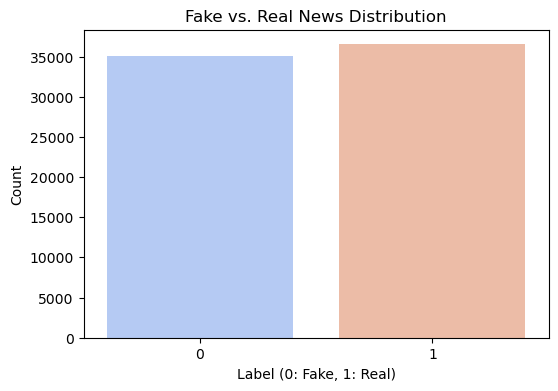

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['label'], palette="coolwarm")
plt.title("Fake vs. Real News Distribution")
plt.xlabel("Label (0: Fake, 1: Real)")
plt.ylabel("Count")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


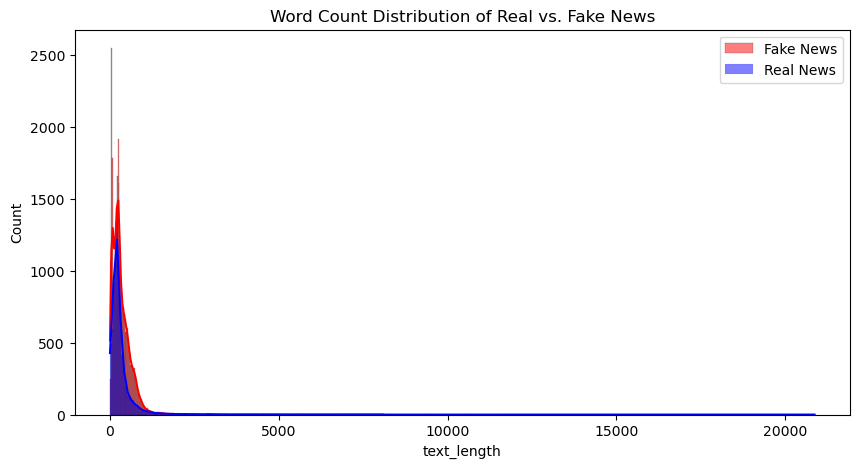

In [7]:
df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(df[df['label']==0]['text_length'], label="Fake News", color="red", kde=True)
sns.histplot(df[df['label']==1]['text_length'], label="Real News", color="blue", kde=True)
plt.legend()
plt.title("Word Count Distribution of Real vs. Fake News")
plt.show()

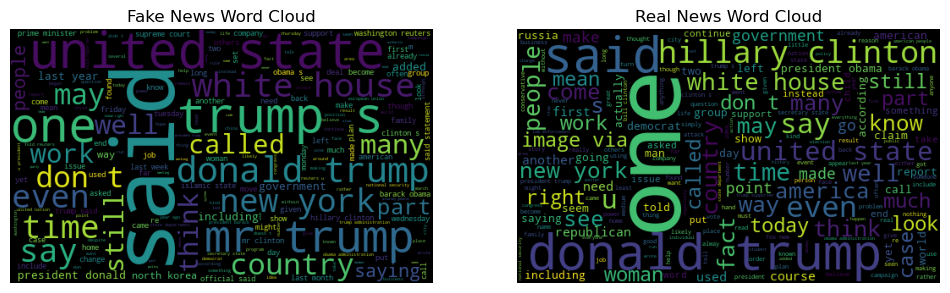

In [8]:
fake_text = " ".join(df[df['label'] == 0]['cleaned_text'])
real_text = " ".join(df[df['label'] == 1]['cleaned_text'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(width=500, height=300, background_color='black').generate(fake_text))
plt.axis('off')
plt.title("Fake News Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=500, height=300, background_color='black').generate(real_text))
plt.axis('off')
plt.title("Real News Word Cloud")

plt.show()

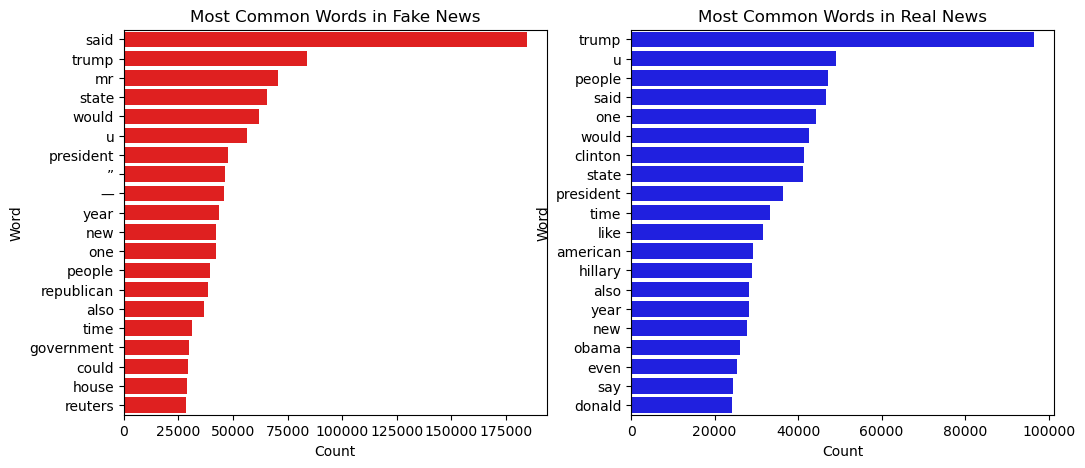

In [9]:
fake_words = Counter(" ".join(df[df['label'] == 0]['cleaned_text']).split()).most_common(20)
real_words = Counter(" ".join(df[df['label'] == 1]['cleaned_text']).split()).most_common(20)

fake_df = pd.DataFrame(fake_words, columns=['Word', 'Count'])
real_df = pd.DataFrame(real_words, columns=['Word', 'Count'])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(y=fake_df['Word'], x=fake_df['Count'], color='red')
plt.title("Most Common Words in Fake News")

plt.subplot(1,2,2)
sns.barplot(y=real_df['Word'], x=real_df['Count'], color='blue')
plt.title("Most Common Words in Real News")

plt.show()

In [10]:
vectorizer = TfidfVectorizer(max_features=5000)  # Extract top 5000 words
X = vectorizer.fit_transform(df['cleaned_text'])

# Convert to DataFrame
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate with original dataset
df_final = pd.concat([df.reset_index(drop=True), X_df], axis=1)

print("TF-IDF Feature Engineering Complete.")

TF-IDF Feature Engineering Complete.


In [11]:
# Define X (features) and y (labels)
X = df_final.drop(columns=['title', 'text', 'cleaned_text', 'label'])  # Drop original text columns
y = df_final['label']

# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data splitting complete. Ready for modeling.")

Data splitting complete. Ready for modeling.



## Pearson Correlation Analysis

To understand feature relationships, we compute the correlation matrix and visualize it using a heatmap.


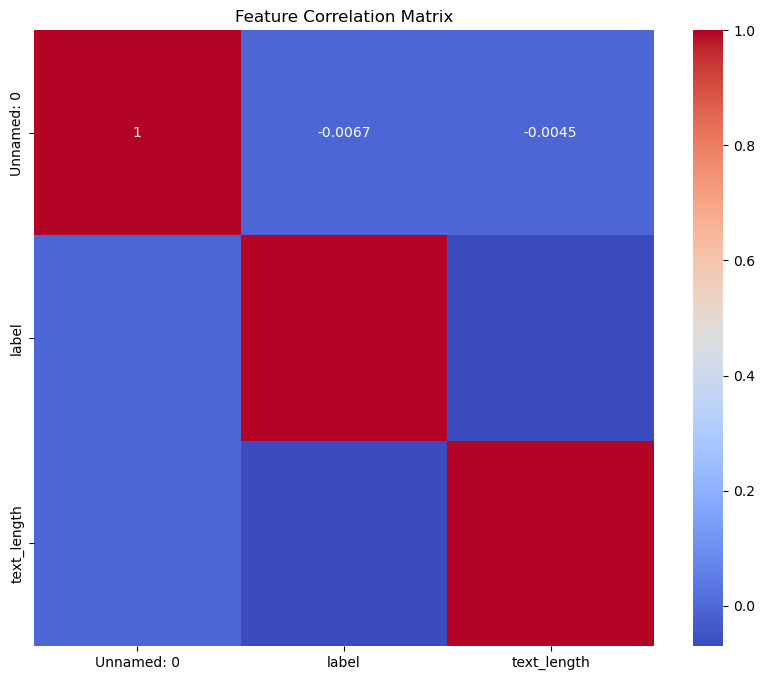

In [12]:

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])

# Compute Pearson correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


## Step 4: Preprocessing and Training Data Development

In this step, we prepare the dataset for machine learning model development. The following steps are included:

1. **Handling Categorical Variables**  
   - Convert categorical variables into dummy variables.

2. **Feature Scaling**  
   - Standardize numeric features using a scaler.

3. **Train-Test Split**  
   - Divide the dataset into training and testing sets.


In [13]:
from sklearn.preprocessing import StandardScaler

# Sample 50% of the dataset to prevent memory overload
df_sample = df.sample(frac=0.5, random_state=42)

# Identify categorical columns and apply Label Encoding to reduce memory usage
categorical_cols = df_sample.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df_sample[col] = le.fit_transform(df_sample[col])

# Standardize numerical features, but only scale if necessary
scaler = StandardScaler()
numeric_cols = df_sample.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    df_sample[col] = scaler.fit_transform(df_sample[[col]])

# Train-test split
X = df_sample.drop(columns=['label'])  # Assuming 'label' is the target variable
y = df_sample['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Preprocessing completed. Data is ready for modeling.")


Preprocessing completed. Data is ready for modeling.



## Step 5: Modeling

We build multiple models to predict the target variable and compare their performance. The following steps are taken:

1. **Train Multiple Models**  
   - Train at least two different models and evaluate their results.

2. **Hyperparameter Tuning**  
   - Tune model parameters for better accuracy.

3. **Model Evaluation**  
   - Choose the best model based on evaluation metrics.


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Convert target variable (y) to categorical if it's continuous
if y_train.dtype in ['float64', 'float32']:
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

# OR, If it's multiclass (more than 2 unique values)
if len(y_train.unique()) > 2:
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

# Train a Logistic Regression Model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Train a Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Train an SVM Model
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Evaluate Models
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))

print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

print("SVM Model Performance:")
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

# Selecting the Best Model
best_model = max([(log_model, accuracy_score(y_test, y_pred_log)),
                  (rf_model, accuracy_score(y_test, y_pred_rf)),
                  (svm_model, accuracy_score(y_test, y_pred_svm))],
                 key=lambda x: x[1])

print(f"Best Model Selected: {best_model[0]} with Accuracy: {best_model[1]}")

Logistic Regression Performance:
              precision    recall  f1-score   support

          -1       0.63      0.60      0.61      3505
           0       0.63      0.66      0.65      3649

    accuracy                           0.63      7154
   macro avg       0.63      0.63      0.63      7154
weighted avg       0.63      0.63      0.63      7154

Accuracy: 0.6292982946603299
Random Forest Performance:
              precision    recall  f1-score   support

          -1       0.89      0.87      0.88      3505
           0       0.87      0.89      0.88      3649

    accuracy                           0.88      7154
   macro avg       0.88      0.88      0.88      7154
weighted avg       0.88      0.88      0.88      7154

Accuracy: 0.8803466592116299
SVM Model Performance:
              precision    recall  f1-score   support

          -1       0.66      0.84      0.74      3505
           0       0.79      0.58      0.67      3649

    accuracy                           0.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the hyperparameter search space
param_dist = {
    'n_estimators': np.arange(50, 300, 50),  # Number of trees
    'max_depth': [None, 10, 20, 30, 40],  # Depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
    'bootstrap': [True, False]  # Whether to use bootstrap sampling
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Apply RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of random parameter combinations to try
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit on training data
random_search.fit(X_train, y_train)

# Print best parameters and accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 40, 'bootstrap': False}
Best Accuracy: 0.8783811564330491


In [17]:
from sklearn.model_selection import GridSearchCV

# Define a refined search space using best parameters from RandomizedSearchCV
param_grid = {
    'n_estimators': [150, 200, 250],  # Adjust based on best results
    'max_depth': [20, 30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Print best parameters and accuracy
print("Best Parameters (Grid Search):", grid_search.best_params_)
print("Best Accuracy (Grid Search):", grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters (Grid Search): {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}
Best Accuracy (Grid Search): 0.8755853222123573


In [18]:
# Use the best parameters from GridSearchCV
best_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

# Evaluate on test set
y_pred_best = best_rf.predict(X_test)

# Print final accuracy
from sklearn.metrics import classification_report, accuracy_score

print("Final Model Performance:")
print(classification_report(y_test, y_pred_best))
print("Final Accuracy:", accuracy_score(y_test, y_pred_best))

Final Model Performance:
              precision    recall  f1-score   support

          -1       0.89      0.87      0.88      3505
           0       0.87      0.89      0.88      3649

    accuracy                           0.88      7154
   macro avg       0.88      0.88      0.88      7154
weighted avg       0.88      0.88      0.88      7154

Final Accuracy: 0.8804864411518032
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.7s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=250; total time=  21.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   6.0s
[CV] END bootstrap=False, max_depth=40, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=  11.6s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True